In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def hit(row, col, grid):
    if grid[row, col] == 1:  
        return np.random.choice([0, 1], p=[0.15, 0.85])  # 85% hit rate
    else:  
        return np.random.choice([0, 1], p=[0.90, 0.10])  # 10% false alarm rate


In [75]:
def los(r1,c1,r2,c2,grid):
    p1 = (r1,c1)
    p2 = (r2,c2)

    #Same point check
    if p1 == p2:
        print("Same point")
        return False

    if grid[r2, c2] == 1:
        print(f"Target cell ({r2},{c2}) is occupied")
        return False

    if grid[r1, c1] == 1:
        print(f"Target cell ({r1},{c1}) is occupied")
        return False

    if p1[0] == p2[0]:
        if p2[1] > p1[1]: #check which point comes first in the columns (moving from left to right)
            for c in range(p1[1]+1,p2[1]): #loop through the columns
                if grid[p1[0], c] == 1: #objectCheck func returns 1 if there is an object in the way, 0 if not
                    print(f"Object in the way @ {p1[0]}, {c}")
                    return False #return false if there is an object in the way and immediately leave the function
                else: #no object in the way
                    print(f"No object @ {p1[0]}, {c}")
        else: #if p2(col) is before p1(col) instead 
            for c in range(p2[1]+1,p1[1]):
                if grid[p1[0], c] == 1:
                    print(f"Object in the way @ {p1[0]}, {c}")
                    return False
                else: #no object in the way
                    print(f"No object @ {p1[0]}, {c}")
        print("No objects in the way (horizontal)")
        return True



    elif p1[1] == p2[1]:    #check which point comes first in the rows (moving from down to up)
        if p2[0] > p1[0]: 
            for r in range(p1[0]+1,p2[0]): #loop through the rows
                if grid[r, p1[1]] == 1: #objectCheck func returns 1 if there is an object in the way, 0 if not
                    print(f"Object in the way @ {r}, {p1[1]}")
                    return False #return false if there is an object in the way and immediately leave the function
                else: #no object in the way
                    print(f"No object @ {r}, {p1[1]}")
        else: #if p2(row) is before p1(row) instead 
            for r in range(p2[0]+1,p1[0]):
                if grid[r, p1[1]] == 1:
                    print(f"Object in the way @ {r}, {p1[1]}")
                    return False
                else: #no object in the way
                    print(f"No object @ {r}, {p1[1]}")
        print("No objects in the way (vertical)")
        return True

    else:
        print(f"Points are not in a straight line. The line {p1} to {p2} are not in a horizontal or vertical line.")
        return False


In [76]:
def visibleMat(r, c, grid):
    visible = np.zeros((grid.shape[0], grid.shape[1]))
    
    # The robot can always see its own cell
    visible[r, c] = 1
    
    # Check visibility to every other cell in the grid
    for row in range(grid.shape[0]):
        if (row,c) != (r,c):
            if los(r, c, row, c, grid):
                visible[row, c] = 1          
    for col in range(grid.shape[1]):
        if (r, col) != (r, c):  # Skip the robot's own position
            if los(r, c, r, col, grid):
                visible[r, col] = 1
    return visible

In [77]:
def logOdds(grid,p0=0.5):
    x0 = np.log(p0/(1-p0)) #EQ 6
    return np.full(grid.shape, x0) # fill a grid with x0

In [78]:
def bayes(xcurr, visible_set, grid, r,c):
    xnew = xcurr.copy()
    
    # Go through all points
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):

            if (visible_set[row, col] == 1): # update only if cell is in LOS
                check = hit(row, col, grid)
                if check == 1:
                    evidence = np.log(0.85 / 0.10)  # log(p_hit / p_fa) EQ7
                else:
                    evidence = np.log((1 - 0.85) / (1 - 0.10))  # log(1-p_hit / 1-p_fa) EQ7 
                
                xnew[row, col] = xcurr[row, col] + evidence # edit beleif
    
    return xnew

In [79]:
def metro(robots,grid,visibleSet):
    n = len(robots)
    comms = np.zeros((n,n)) #creating a matrix to see the communication between robots. 1 = can communicate, 0 = cannot communicate

    for i in range(n): # build the communication matrix for n robots
        for j in range(i+1,n):
            r1,c1= robots[i]
            r2,c2 = robots[j]
            if los(r1,c1,r2,c2,grid):
                comms[i,j] = 1
                comms[j,i] = 1

    degrees = []
    for i in range(n): # get the degrees for n robots from the communication matrix
        degree = np.sum(comms[i])
        degrees.append(degree)

    weights = np.zeros((n,n))
    for i in range(n):
        selfWeight = 1
        totalWeight = 0
        for j in range(n):
            if (comms[i,j] == 1) & (i != j):
                w = 1/(1+max(degrees[i],degrees[j]))
                weights[i,j] = w
                totalWeight += w

        weights[i,i] = selfWeight - totalWeight
    return weights



In [80]:
def avgCon(beliefs, weights):
    n = len(beliefs)
    finalBeliefs = []

    for i in range(n):
        rows,cols = beliefs[0].shape
        updateBelief = np.zeros((rows,cols))
    
        for j in range(n):
            updateBelief = updateBelief + weights[i,j]*beliefs[j]
            
        finalBeliefs.append(updateBelief)

    return finalBeliefs

In [81]:
def logOddsProb(log):
    return 1/(1+np.exp(-log))

In [82]:
def sim(robots,grid,K=20):
    n = len(robots)
    beliefs = []
    for i in range(n): # Init beliefs
        beliefs.append(logOdds(grid))

    
    visibleSets = []
    for i in range(n): 
        r = robots[i][0]
        c = robots[i][1]
        visibleSet = visibleMat(r, c, grid)
        visibleSets.append(visibleSet)

    metroWeights = metro(robots,grid,visibleSets[0])

    for k in range(K):
        newBeliefs = []
        for j in range(n):
            r = robots[j][0]
            c = robots[j][1]
            newBelief = bayes(beliefs[j], visibleSets[j], grid, r, c)        
            newBeliefs.append(newBelief)
        
        beliefs = avgCon(newBeliefs,metroWeights)

    beliefProb = []
    for b in beliefs:
        beliefProb.append(logOddsProb(b))
        
    return beliefProb

In [83]:
def nosim(robots,grid,K=20):
    n = len(robots)
    beliefs = []
    for i in range(n): # Init beliefs
        beliefs.append(logOdds(grid))

    
    visibleSets = []
    for i in range(n): 
        r = robots[i][0]
        c = robots[i][1]
        visibleSet = visibleMat(r, c, grid)
        visibleSets.append(visibleSet)

    metroWeights = metro(robots,grid,visibleSets[0])

    for k in range(K):
        newBeliefs = []
        for j in range(n):
            r = robots[j][0]
            c = robots[j][1]
            newBelief = bayes(beliefs[j], visibleSets[j], grid, r, c)        
            newBeliefs.append(newBelief)
        beliefs = newBeliefs # no coordination/ avgCon

    beliefProb = []
    for b in beliefs:
        beliefProb.append(logOddsProb(b))
        
    return beliefProb

No objects in the way (vertical)
No objects in the way (vertical)
No object @ 2, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No object @ 4, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No object @ 4, 0
No object @ 5, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No object @ 4, 0
No object @ 5, 0
No object @ 6, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No object @ 4, 0
No object @ 5, 0
No object @ 6, 0
No object @ 7, 0
No objects in the way (vertical)
No object @ 2, 0
No object @ 3, 0
No object @ 4, 0
No object @ 5, 0
No object @ 6, 0
No object @ 7, 0
No object @ 8, 0
No objects in the way (vertical)
No objects in the way (horizontal)
No object @ 1, 1
No objects in the way (horizontal)
No object @ 1, 1
No object @ 1, 2
No objects in the way (horizontal)
No object @ 1, 1
No object @ 1, 2
No object @ 1, 3
No objects in the wa

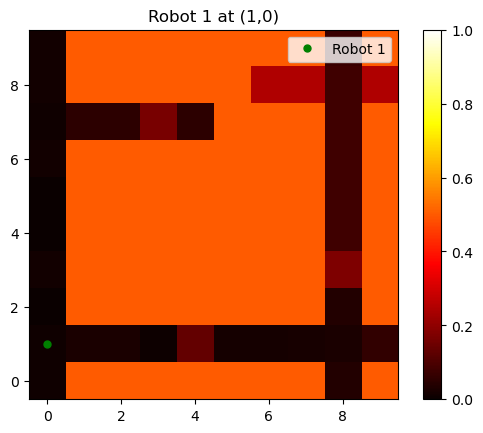

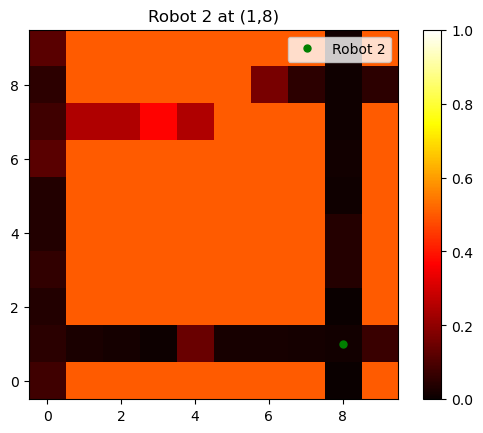

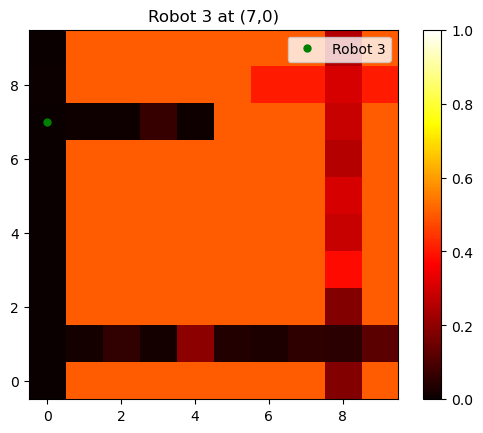

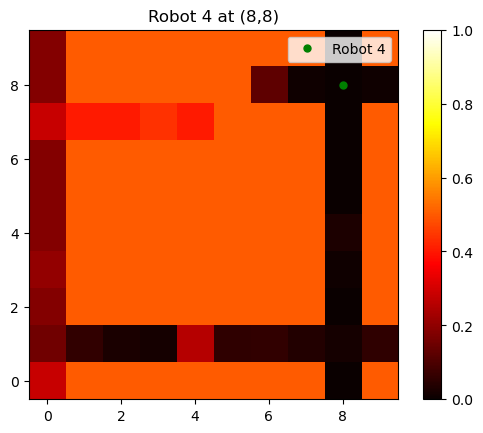

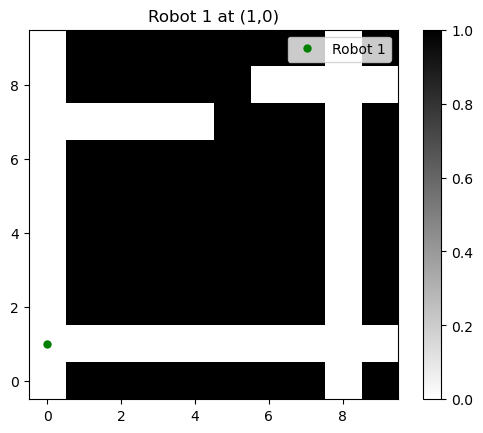

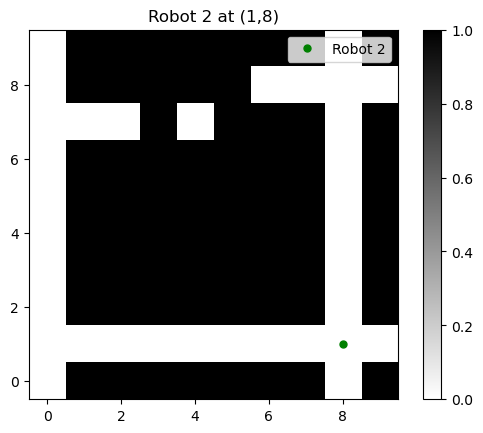

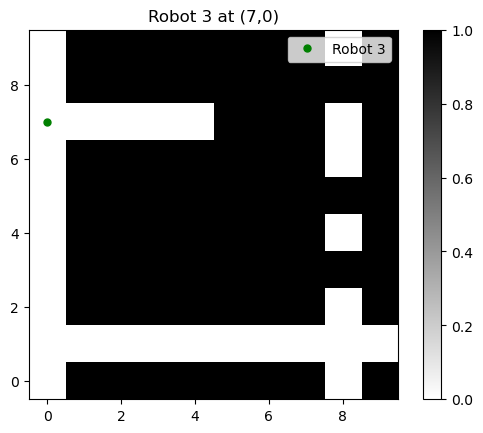

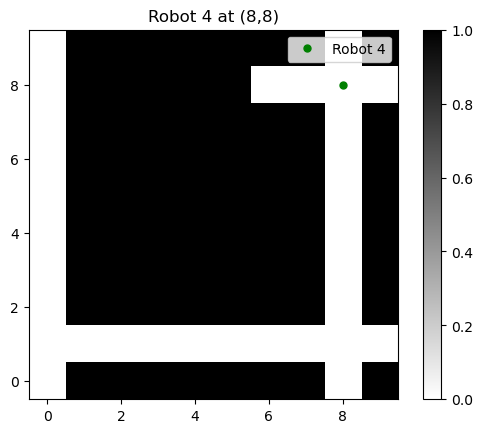

In [84]:
# Main
robots = [[1,0],[1,8],[7,0],[8,8]]
grid = np.loadtxt('room_10x10.csv', delimiter=',')
results = sim(robots, grid, K=5)  

for i in range(len(robots)): #Heat maps
    plotData = results[i]
    
    plt.imshow(plotData, cmap='hot', origin='lower', vmin=0, vmax=1) 
    r, c = robots[i]
    plt.plot(c, r, 'go', markersize=5, label=f'Robot {i+1}') #robot pos
    plt.title(f'Robot {i+1} at ({r},{c})')
    plt.legend()
    plt.colorbar()
    plt.show()


threshold = 0.3
plotData = []
for i in range(len(robots)): 
    plotData = results[i]
    bin = plotData>threshold
    
    plt.imshow(bin, cmap='binary', origin='lower', vmin=0, vmax=1) 
    r, c = robots[i]
    plt.plot(c, r, 'go', markersize=5, label=f'Robot {i+1}') #robot pos
    plt.title(f'Robot {i+1} at ({r},{c})')
    plt.legend()
    plt.colorbar()
    plt.show()